In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/MesoNet Baseline'
except ModuleNotFoundError:
    pass

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/MesoNet Baseline


In [4]:

import numpy as np

import sys
from classifiers import *   # MesoNet
from weights import *       # MesoNet

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

IMGWIDTH = 256

# MESO_4 

class Classifier:
    def __init__():
        self.model = 0
    
    # def predict(self, x):
    #     return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    # def load(self, path):
    #     self.model.load_weights(path)

class Meso4_copy(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

        


In [21]:
# Baseline Classifiers variables
MESO4 = Meso4()
MESO_INCEPTION = MesoInception4()
MODEL = Meso4_copy()

WEIGHTS_MESO4 = 'weights/Meso4_DF.h5'
WEIGHTS_MESOINCEPTION = 'weights/MesoInception_DF.h5'

# Datasets
CELEB_AVG = '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/Celeb-DF-v2/Celeb-avg'
CELEB_RND = '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/Celeb-DF-v2/Celeb-rnd'

# Settings
DATASET = CELEB_RND
CLASSIFIER = MODEL

# Setting weights based on classifier type
WEIGHTS = ''
if CLASSIFIER is MESO4:
  WEIGHTS = WEIGHTS_MESO4
elif CLASSIFIER is MESO_INCEPTION:
  WEIGHTS = WEIGHTS_MESOINCEPTION

WEIGHTS = WEIGHTS_MESO4

In [23]:
# 1 - Load the model and its pretrained weights

# classifier = MESO4    # Choose Classifier
CLASSIFIER.model.load_weights(WEIGHTS)
# !pwd
# !ls

In [24]:
# 2 - Minimial image generator
# We did use it to read and compute the prediction by batchs on test videos
# but do as you please, the models were trained on 256x256 images in [0,1]^(n*n)

dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        DATASET,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

Found 6229 images belonging to 2 classes.


In [28]:
Y_pred = CLASSIFIER.model.predict(generator, verbose=1)
Y_true = generator.classes

195/195 [==============================] - 20s 100ms/step


In [29]:
# 3 - Predict
# X, y = generator.next()
print('Predicted :', Y_pred, '\nReal class :', Y_true)

Predicted : [[0.44733125]
 [0.09313794]
 [0.43455967]
 ...
 [0.63899136]
 [0.17447491]
 [0.7729747 ]] 
Real class : [0 0 0 ... 1 1 1]


In [30]:
y_pred_keras = Y_pred.ravel
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

NameError: ignored

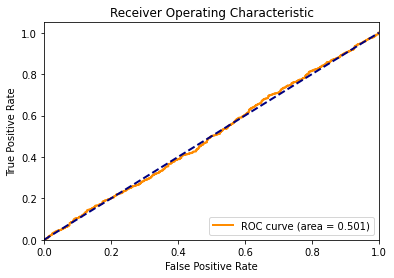

In [31]:

fpr, tpr, _ = roc_curve(Y_true, Y_pred)
try:
    roc_auc = auc(fpr, tpr)
except:
    pass
    
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
for thrshld in map(lambda x: x/20, range(0,20)):
    y_pred = (Y_pred > thrshld).astype(int)
    print(f'\nTHRESHOLD = {thrshld}')
    print(f'\nCONFUSION MATRIX\n{confusion_matrix(Y_true, y_pred)}')
    print(f'\nCLASSIFICATION REPORT\n{classification_report(Y_true, y_pred, target_names = ["REAL", "FAKE"])}\n\n')
    print('________________________________________________________________\n\n')


THRESHOLD = 0.0

CONFUSION MATRIX
[[   0  590]
 [   0 5639]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.00      0.00      0.00       590
        FAKE       0.91      1.00      0.95      5639

    accuracy                           0.91      6229
   macro avg       0.45      0.50      0.48      6229
weighted avg       0.82      0.91      0.86      6229



________________________________________________________________



THRESHOLD = 0.05

CONFUSION MATRIX
[[  27  563]
 [ 239 5400]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.10      0.05      0.06       590
        FAKE       0.91      0.96      0.93      5639

    accuracy                           0.87      6229
   macro avg       0.50      0.50      0.50      6229
weighted avg       0.83      0.87      0.85      6229



________________________________________________________________



THRESHOLD = 0.1

CONFUSION MATRIX
[[

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



CONFUSION MATRIX
[[ 309  281]
 [3015 2624]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.09      0.52      0.16       590
        FAKE       0.90      0.47      0.61      5639

    accuracy                           0.47      6229
   macro avg       0.50      0.49      0.39      6229
weighted avg       0.83      0.47      0.57      6229



________________________________________________________________



THRESHOLD = 0.45

CONFUSION MATRIX
[[ 348  242]
 [3367 2272]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.09      0.59      0.16       590
        FAKE       0.90      0.40      0.56      5639

    accuracy                           0.42      6229
   macro avg       0.50      0.50      0.36      6229
weighted avg       0.83      0.42      0.52      6229



________________________________________________________________



THRESHOLD = 0.5

CONFUSION MATRIX
[[ 382  208]
 [3749

In [ ]:


# # import numpy as np

# # import sys
# # sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/MesoNet')
# # from classifiers import *
# # from weights import *

# # from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # 1 - Load the model and its pretrained weights
# classifier = MesoInception4()
# !pwd
# classifier.load('MesoNet/weights/MesoInception_DF.h5')

# # 2 - Minimial image generator
# # We did use it to read and compute the prediction by batchs on test videos
# # but do as you please, the models were trained on 256x256 images in [0,1]^(n*n)

# dataGenerator = ImageDataGenerator(rescale=1./255)
# generator = dataGenerator.flow_from_directory(
#         '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder/Celeb-DF-v2/Celeb-avg',
#         target_size=(256, 256),
#         batch_size=10,
#         class_mode='binary',
#         subset='training')

# # 3 - Predict
# X, y = generator.next()
# print('Predicted :', classifier.predict(X), '\nReal class :', y)

